<b>Please install the following libraries to run this project:</b>

In [1]:
#pip install ipython-sql
#pip install mysqlclient
#pip install mysql-connector-python
#pip install pymysql
#pip install vaderSentiment
#pip install -U textblob
#pip install skforecast --user

<b>Library Importation</b>

In [379]:
import numpy as np              
import pandas as pd             
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns  # library for making statistical graphics in Python.

import mysql.connector
import pymysql

from pyspark.sql import SparkSession

# Load vaderSentimental library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from joblib import dump, load


import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Create and initialise an object
sentiment = SentimentIntensityAnalyzer()

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster



[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'skforecast.ForecasterAutoregMultiOutput'

<b>Global Variables:</b>

In [15]:
# Path to data set
csv_file = "file:///home/hduser/Downloads/work2/ProjectTweets.csv"

In [18]:
# Parameters below will be used to beautify the graphs

# Define the graph style
plt.style.use("seaborn-whitegrid");

# define size and autolayout
# Autolayout: the graph will fit automaticaly on the screen resoltion
plt.rc("figure", autolayout=True, figsize=(11, 4));

# Defining axes atributes of the graph 
plt.rc(
    "axes",
    labelweight = "bold",
    labelsize = "large",
    titleweight = "bold",
    titlesize = 14,
    titlepad = 10,
);
# Defining axes atributes of the graph 
plot_params = dict(
    color = "0.75",
    style = ".-",
    markeredgecolor = "0.25",
    markerfacecolor = "0.25",
    legend = False,
);

# Command to autoformat date axis
plt.gcf().autofmt_xdate();

# format the graph as retina style
#%config InlineBackend.figure_format = 'retina';

<Figure size 1100x400 with 0 Axes>

# Data Understanding - Part 1

<b>Creating a new spark session and load CSV data to a temporary spark table and to a spark dataframe: </b>

In [16]:
#Import pyspark SQL
from pyspark.sql import SparkSession        

# Create a SparkSession
spark = (SparkSession
  .builder
  .appName("SparkSQL")
  .getOrCreate())

# Read and create a temporary view
# The dataset doesnt contain header, so header = false
# toDF to define appropriated column name
dfTwitter = (spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "false")
  .load(csv_file)
  .toDF('id', 'seq', 'date', 'query', 'user', 'tweet'))

dfTwitter.createOrReplaceTempView("tblTempTwitter")


<b>Printing some records to take a first look on the dataset:</b>

In [17]:
spark.sql("""SELECT * FROM tblTempTwitter""").show(10)

+---+----------+--------------------+--------+---------------+--------------------+
| id|       seq|                date|   query|           user|               tweet|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [18]:
spark.sql("""SELECT * FROM tblTempTwitter where query != 'NO_QUERY'""").show(10)

+---+---+----+-----+----+-----+
| id|seq|date|query|user|tweet|
+---+---+----+-----+----+-----+
+---+---+----+-----+----+-----+



In [19]:
spark.sql("""SELECT user, COUNT(user) as total FROM tblTempTwitter GROUP BY user ORDER BY total desc;""").show(20)



+---------------+-----+
|           user|total|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
|   SongoftheOss|  227|
|      Jayme1988|  225|
|         keza34|  219|
| ramdomthoughts|  216|
|      shanajaca|  213|
|         wowlew|  212|
|     nuttychris|  211|
|   TraceyHewins|  211|
|   thisgoeshere|  207|
|     Spidersamm|  205|
+---------------+-----+
only showing top 20 rows



Looking for null or blank date values

In [20]:
spark.sql("""SELECT user, tweet FROM tblTempTwitter where date is null or date =='';""").show(20)


+----+-----+
|user|tweet|
+----+-----+
+----+-----+



# Data Preparation

## SPARK HIVE

Creating a Database, table and proccessing data in Hive Metastore. 
<br/>
<b>Database name:</b> dbTwitter
<br/>
<b>Table name:</b> tblTwitter
<br/>
<b>Operation:</b> Store the CSV file in a permanent table in HIVE (Spark). This hive table will be used as a performance comparation with MySQL
<br/>


In [22]:
#Creating a Database dbTwitter in Hive
spark.sql("CREATE DATABASE IF NOT EXISTS dbTwitter")



2023-10-18 09:50:42,644 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-10-18 09:50:42,646 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-10-18 09:50:46,798 WARN metastore.ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
2023-10-18 09:50:46,798 WARN metastore.ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore hduser@127.0.1.1
2023-10-18 09:50:47,225 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
2023-10-18 09:50:47,242 ERROR metastore.RetryingHMSHandler: AlreadyExistsException(message:Database dbtwitter already exists)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_database(HiveMetaStore.java:925)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeM

DataFrame[]

Using spark.sql() method "CREATE TABLE" to create a table in Hive from the spark temporary view tblTempTwitter.

In [23]:
#Create a Table in Hive tblTwitter on the bdTwitter database.
spark.sql("CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitter (id Int, seq Double, date String, query String, user String, tweet String)")



2023-10-18 09:50:55,618 WARN analysis.ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
2023-10-18 09:50:56,236 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
2023-10-18 09:50:56,471 WARN conf.HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
2023-10-18 09:50:56,471 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-10-18 09:50:56,472 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-10-18 09:50:56,529 ERROR metastore.RetryingHMSHandler: AlreadyExistsException(message:Table tbltwitter already exists)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_table_core(HiveMetaStore.java:1416)
	at org.apach

DataFrame[]

Inserting data from the spark temporary view tblTempTwitter into the Hive table tblTwitter:

In [29]:
#query to test if the table has rows, if has is because the code is been processed again and we do not need to reproccess
query = spark.sql("Select * from dbTwitter.tblTwitter LIMIT 1;")

#Test if the table is empty
if not query:
    #If the table is empty, them execute the code to fill with the dataset data
    #Insert into Hive tblTwitter using the spar temp view tblTempTwitter. 
    spark.sql("INSERT INTO TABLE dbTwitter.tblTwitter SELECT * FROM tblTempTwitter")    
else:
    print("Table is not empty!")


Table is not empty!


In [26]:
#Lets view the data in the hive table
spark.sql("SELECT * FROM dbTwitter.tblTwitter").show(10)

+------+-------------+--------------------+--------+---------------+--------------------+
|    id|          seq|                date|   query|           user|               tweet|
+------+-------------+--------------------+--------+---------------+--------------------+
|545133|2.201337104E9|Tue Jun 16 20:08:...|NO_QUERY|      alt_ducky|@miss_clariss oh ...|
|545134|2.201337108E9|Tue Jun 16 20:08:...|NO_QUERY|     CourtneyVR|Failed my WOF. Wi...|
|545135|2.201337287E9|Tue Jun 16 20:08:...|NO_QUERY|    melissaholt|Watching the firs...|
|545136|2.201337425E9|Tue Jun 16 20:08:...|NO_QUERY|       itznesha|my computer is in...|
|545137|2.201337512E9|Tue Jun 16 20:08:...|NO_QUERY|    lovinmyboys|Worked out my upp...|
|545138|2.201337757E9|Tue Jun 16 20:08:...|NO_QUERY|     mikerbrant|OMG I got my new ...|
|545139|2.201338077E9|Tue Jun 16 20:08:...|NO_QUERY|         daulex|my back has flare...|
|545140|2.201338113E9|Tue Jun 16 20:08:...|NO_QUERY|    CaliHeather|I am starting to ...|
|545141|2.

## MySQL

Creating a Database, tables and proccess data with MySQL
<br/>
<b>Database name:</b> dbTwitter
<br/>
<b>Table names:</b> tblTwitter, tblTwitterPrep
<br/>
<b>Details:</b> 
<br/>
MySQL is used to do the Data Preparation in this project.
<br/>
New tables were created, new features, data transformation, and all necessary steps to prepare the data to be fit on the forecast model.

Please intall the my sql connector version 8.1.0

<b>PLEASE, RUN THE COMMANDS BELOW ON TERMINAL TO CREATE AND GRANT PERMISSIONS TO user1:</b>
<br/>
<br/>
mysql -u root -p
<br/>
CREATE USER 'user1'@'%%' IDENTIFIED BY 'Pass@word1';
<br/>
GRANT ALL PRIVILEGES ON * . * TO 'Pass@word1'@'%%';
<br/>
FLUSH PRIVILEGES;
<br/>

<b>Configuring a new connection to the localhost Mysql server:</b>

In [3]:
# Creating a connection to the mySQL database 
connMySQL = pymysql.connect(host = 'localhost',
                             user = 'user1',
                             password = 'Pass@word1',
                             db = 'dbTwitter')

cursor = connMySQL.cursor()

<b>Creating a new database and the first table on MySQL:</b>

In [32]:

#Creating a new database if not exists
cursor.execute("CREATE DATABASE IF NOT EXISTS dbTwitter;")
#Use the dbTwitter in the context
cursor.execute("USE dbTwitter;")

#Creating a new table if not exists
cursor.execute("CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitter (id NUMERIC, seq NUMERIC, date VARCHAR(50), query VARCHAR(50), user VARCHAR(50), tweet TEXT)")

0

<b>Copy the data from Hive table to the correspondent table in MySQL: </b>

In [13]:
#COPY the data from HIVE table to My SQL table

query = connMySQL.query('SELECT id FROM dbTwitter.tblTwitter LIMIT 1;')

#Test if the table is empty
if not query:
    # convert the spark dataframe to pandas dataframe to iterate 
    dfPandasTwitter = dfTwitter.toPandas()
    
    #If the table is empty, them execute the code to fill with the dataset data
    # reading the columns to use on the insert clause
    cols = ",".join([str(i) for i in dfPandasTwitter.columns.tolist()])

    # Insert on the mySQL table all records from SPark SQL
    for i, row in dfPandasTwitter.iterrows():
        sql = "INSERT INTO tblTwitter (" + cols + ") VALUES (" + "%s," * (len(row) - 1) + "%s)"
        cursor.execute(sql, tuple(row))
        
        # the connection is not autocommitted by default, so commit command is necessary to save the changes
        connMySQL.commit()
else:
    print ("This table is not empty!")



This table is not empty!


<b>Creating a new table with the new necessary features:</b>
<br/>
<br/>
The idea is keeping the original table to be used in the performance comparision, all the data preparation will be processed in this new table.
<br/>
<br/>
<b>New features:</b>
<li>date_custom: Date</li>
<li>week: Char(3)</li>
<li>hour: Int</li>
<li>minute: Int</li>
<li>second: Int</li>
<li>day: Int</li>
<li>month: Int</li>
<li>year: Int</li>
<li>sentiment: Double</li>

In [9]:
# Creating the new table to start the data preparation
# It was excluded 
cursor.execute("""CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitterPreparation (
                id Int, 
                date VARCHAR(50), 
                user VARCHAR(50),                 
                tweet TEXT, 
                tweet_review TEXT, 
                date_custom Date,
                week CHAR(3), 
                hour Int, 
                minute Int, 
                second Int, 
                day Int, 
                month Int, 
                year Int, 
                sentiment_vader Double,
                sentiment_blob Double,
                INDEX (id))
              """)

connMySQL.commit()

In [10]:

#cursor.execute("DROP TABLE dbTwitter.tblTwitterPreparation;")
#connMySQL.commit()

<b>Inserting data to the Data Preparation table (tblTwitterPrep) transforming data during the proccess:</b>
<br/>
<br/>
Substring function is used to split the original date value to separeted columns like day, year, hour... These columns can be usefull to plot graphs or to fit in the Machine Learning models.
<br/>
Switch case is used to transform the text value of month (apr, may, jun) into a number value (4, 5 ,6).
<br/>
a DD/MM/YYYY will be processed after this step.
<br/>
<br/>
<b>Original date format:</b> Mon Apr 06 22:19:45 PDT 2009	
<br/>
.

In [11]:
query = connMySQL.query('SELECT id FROM dbTwitter.tblTwitterPreparation LIMIT 1;')

#Test if the table is empty
if not query:
    #If the table is empty, them execute the code to fill with the dataset data    
    
    cursor.execute("""INSERT INTO dbTwitter.tblTwitterPreparation 
                  (id, date, user, tweet, 
                  tweet_review, date_custom, 
                  week, hour, minute, second, 
                  day, month, year, sentiment_vader, sentiment_blob)
                  SELECT id, 
                  date, 
                  user, 
                  tweet,
                  NULL,
                  NULL,
                  SUBSTR(date, 1, 3), 
                  SUBSTR(date, 12, 2), 
                  SUBSTR(date, 15, 2),                    
                  SUBSTR(date, 18, 2),                                      
                  SUBSTR(date, 9, 2),                                                        
                  CASE SUBSTR(date, 5, 3)                      
                      WHEN 'apr' THEN 4
                      WHEN 'may' THEN 5
                      WHEN 'jun' THEN 6                      
                      ELSE NULL
                  END,   
                  SUBSTR(date, 25, 4),                                                                          
                  0.0,  
                  0.0
                  FROM dbTwitter.tblTwitter;""")   
    
    connMySQL.commit()
    
else:
    print("Table is not empty!")



<b>Creating a YYYY/MM/DD date value:</b>

In [12]:

sql = """UPDATE dbTwitter.tblTwitterPreparation t1, dbTwitter.tblTwitterPreparation t2 
SET t1.date_custom = STR_TO_DATE( 
         CONCAT( t2.day, '/', t2.month, '/', t2.year ), '%d/%m/%Y')
WHERE t1.id = t2.id"""

cursor.execute(sql)

connMySQL.commit()

 - a positive sentiment, compound ≥ 0.05.
 - a negative sentiment, compound ≤ -0.05.
 - a neutral sentiment, the compound is between ]-0.05, 0.05[


In [ ]:

#df_Sentimental_Analysis.at[i,'compound'] = sent['compound']
#if float(sent['compound']) >= 0.05:
#    df_Sentimental_Analysis.at[i,'sentiment'] = 'positive'
#    positive += 1
#elif float(sent['compound']) <= -0.05:
#    df_Sentimental_Analysis.at[i,'sentiment'] = 'negative'
#    negative += 1
#else:
#    df_Sentimental_Analysis.at[i,'sentiment'] = 'neutral'
#    neutral += 1

#### Calculating the sentiment (Vader and Blob)

Each tweet will have the text sentiment calculated using Vader and Blob.
<br/>
This is an step to prepare the data for forecasting.
<br/>
<br/>
<b><span style="color:red">I strongly do not recommend </span>to run the vader and blob calculation step below. Even using index to tunning the table, this step took more than one hour to be processed. Instead you can restore the database backup submitted.



In [4]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

#stop = stopwords.words('english')

#print(get_text_processing("This bad, is a: test; for' the stop wonderful words function, try again, the a an if this those work!"))

#testimonial = TextBlob(get_text_processing("This bad is a test for the stop wonderful words function, try again, the a an if this those work!"))
#print(testimonial.sentiment)
#print(testimonial.sentiment[0])

In [5]:
#Loading all the rows to be proccessed with the sentiment
dfTweets = pd.read_sql(sql = "select id, tweet from dbTwitter.tblTwitterPreparation", con = connMySQL)


In [6]:
#Loading all the rows to be proccessed with the sentiment
#dfTweets = pd.read_sql(sql = "select id, tweet from dbTwitter.tblTwitterPreparation", con = connMySQL)

#Iterate on the dataset to calculate the sentiment of each tweet and store on the database
for i, row in dfTweets.iterrows():

    tweet_reviewed = get_text_processing(row["tweet"])
    #tweet_reviewed = tweet_reviewed.replace("'", "")
    #tweet_reviewed = tweet_reviewed.replace('"', '')
        
    #print("tweet_reviewed: " + tweet_reviewed)
        
    #Calculate the sentiment
    sent_vader = sentiment.polarity_scores(tweet_reviewed)['compound']
    sent_blob = TextBlob(tweet_reviewed).sentiment[0]
    
    sql = "UPDATE dbTwitter.tblTwitterPreparation SET "
    sql += "sentiment_vader = " + str(sent_vader) + ", "
    sql += "sentiment_blob = " + str(sent_blob) + ", "
    sql += "tweet_review = '" + str(tweet_reviewed) + "' "
    sql += " WHERE id = " + str(row["id"]) + ";"
    
    #print("sql: " + sql)
    
    #print("id: " + str(row["id"]))

    cursor.execute(sql)    
    # the connection is not autocommitted by default, so commit command is necessary to save the changes
    connMySQL.commit()
    
    #break

    

# Data Understanding - Part 2

Having the original date value splitted in different columns will allow to performing better analysis on the data quality.
<br/>
Group by clauses are now possible (or at least easier) to be performed and some analysis can be prepared, like:
<li>Searching for missing tweets per day</li>
<li>Searching for missing tweets per hour</li>
<li>Analysing the weight difference between days/months</li>

### Average sentiment per day

In [31]:
sql1 = """SELECT CONVERT(date_custom, DATE) as date, 
                AVG(sentiment_vader) as sentiment_vader, 
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
GROUP BY CONVERT(date_custom, DATE)
ORDER BY CONVERT(date_custom, DATE)"""

dfTweetsPredict1 = pd.read_sql(sql = sql1, con = connMySQL)

#sql2 = """SELECT DATE(date_custom) as date, AVG(sentiment) as sentiment
#FROM dbTwitter.tblTwitterPreparation
#WHERE sentiment != 0
#GROUP BY date_custom
#ORDER BY date_custom"""

#dfTweetsPredict2 = pd.read_sql(sql = sql2, con = connMySQL)


In [32]:

dfTweetsPredict1

,date,sentiment_vader,sentiment_blob
0,2009-04-06,0.155006,0.094019
1,2009-04-07,0.170903,0.099391
2,2009-04-17,0.208811,0.121702
3,2009-04-18,0.186284,0.112139
4,2009-04-19,0.191934,0.114881
5,2009-04-20,0.183340,0.111665
6,2009-04-21,0.182650,0.109819
7,2009-05-01,0.184256,0.111823
8,2009-05-02,0.186152,0.114778
9,2009-05-03,0.178122,0.108815


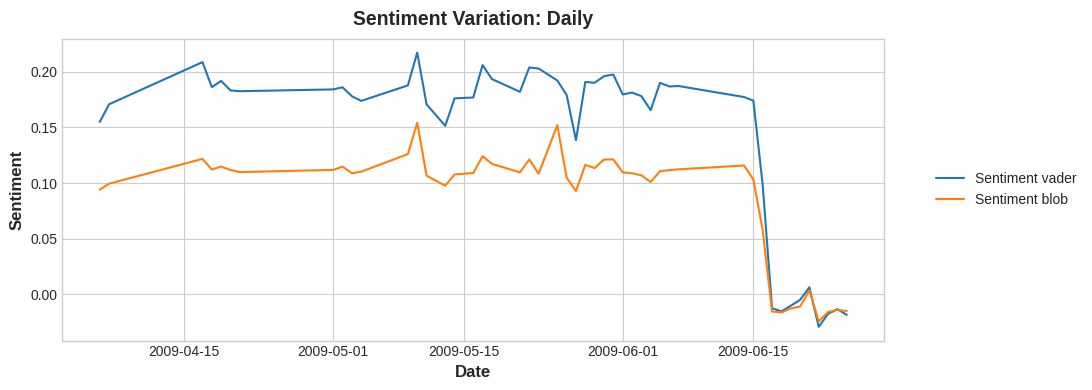

In [33]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict1['date'], dfTweetsPredict1['sentiment_vader'], label='Sentiment vader');  # Plot first line of data.
ax.plot(dfTweetsPredict1['date'], dfTweetsPredict1['sentiment_blob'], label='Sentiment blob');  # Plot second line of data

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1.25, 0.5)) #Better positioning the legend

### Average Sentiment per hour

In [34]:
sql2 = """SELECT DATE_FORMAT(concat(year, '/', month, '/', day, ' ', hour, ':', '00'), '%Y/%m/%d %H:%i') as date, 
        AVG(sentiment_vader) as sentiment_vader,
        AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
GROUP BY DATE_FORMAT(concat(year, '/', month, '/', day, ' ', hour, ':', '00'), '%Y/%m/%d %H:%i')
ORDER BY DATE_FORMAT(concat(year, '/', month, '/', day, ' ', hour, ':', '00'), '%Y/%m/%d %H:%i')"""

dfTweetsPredict2 = pd.read_sql(sql = sql2, con = connMySQL)


In [35]:
pd.set_option('display.max_rows', None)

dfTweetsPredict2

,date,sentiment_vader,sentiment_blob
0,2009/04/06 22:00,0.143017,0.085042
1,2009/04/06 23:00,0.163088,0.100071
2,2009/04/07 00:00,0.175061,0.103789
3,2009/04/07 01:00,0.170414,0.105734
4,2009/04/07 02:00,0.181674,0.102587
5,2009/04/07 03:00,0.168963,0.099639
6,2009/04/07 04:00,0.172308,0.105800
7,2009/04/07 05:00,0.165456,0.091903
8,2009/04/07 06:00,0.171277,0.098949
9,2009/04/07 07:00,0.167515,0.086663


<Figure size 1100x400 with 0 Axes>

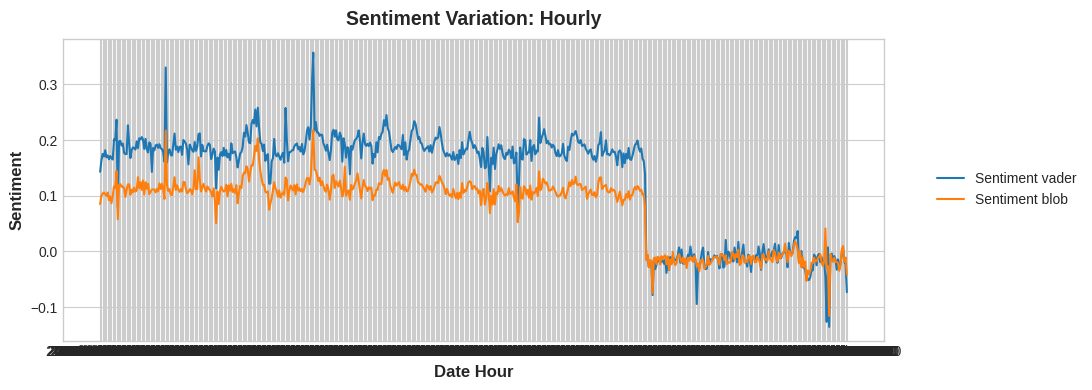

In [36]:

# Command to autoformat date axis
plt.gcf().autofmt_xdate();

# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict2['date'], dfTweetsPredict2['sentiment_vader'], label='Sentiment vader');  # Plot first line of data.
ax.plot(dfTweetsPredict2['date'], dfTweetsPredict2['sentiment_blob'], label='Sentiment blob');  # Plot second line of data

ax.set_xlabel('Date Hour');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Hourly");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1.25, 0.5)) #Better positioning the legend

### Average Sentiment per day - Only last hour (23:00)

In [37]:
sql3 = """SELECT date_custom as date, 
                AVG(sentiment_vader) as sentiment_vader, 
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
WHERE hour = 23
GROUP BY date_custom
ORDER BY date_custom"""

dfTweetsPredict3 = pd.read_sql(sql = sql3, con = connMySQL)



In [38]:
dfTweetsPredict3

,date,sentiment_vader,sentiment_blob
0,2009-04-06,0.163088,0.100071
1,2009-04-18,0.185251,0.114516
2,2009-04-19,0.181441,0.110693
3,2009-04-20,0.178800,0.108793
4,2009-05-01,0.187770,0.107055
5,2009-05-02,0.170637,0.107639
6,2009-05-03,0.168804,0.098976
7,2009-05-09,0.206306,0.140452
8,2009-05-11,0.174763,0.107772
9,2009-05-13,0.167412,0.109247


<Figure size 1100x400 with 0 Axes>

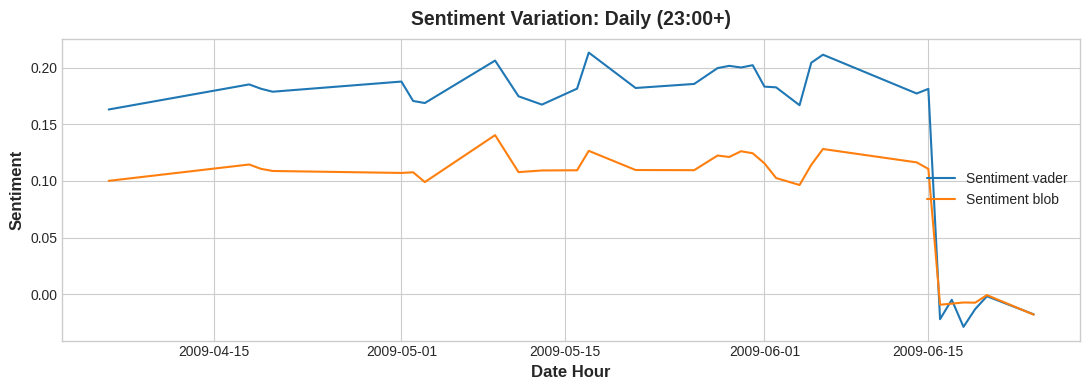

In [39]:

# Command to autoformat date axis
plt.gcf().autofmt_xdate();

# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict3['date'], dfTweetsPredict3['sentiment_vader'], label='Sentiment vader');  # Plot first line of data.
ax.plot(dfTweetsPredict3['date'], dfTweetsPredict3['sentiment_blob'], label='Sentiment blob');  # Plot second line of data

ax.set_xlabel('Date Hour');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily (23:00+)");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1, 0.5)) #Better positioning the legend

### Average sentiment per day - Textblob Comparative with/without 0 values

In [40]:
sql4 = """SELECT CONVERT(date_custom, DATE) as date, 
                AVG(sentiment_blob) as sentiment_blob                
FROM dbTwitter.tblTwitterPreparation
WHERE sentiment_blob != 0
GROUP BY CONVERT(date_custom, DATE)
ORDER BY CONVERT(date_custom, DATE)"""

dfTweetsPredict4 = pd.read_sql(sql = sql4, con = connMySQL)


sql44 = """SELECT CONVERT(date_custom, DATE) as date,                 
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
GROUP BY CONVERT(date_custom, DATE)
ORDER BY CONVERT(date_custom, DATE)"""

dfTweetsPredict44 = pd.read_sql(sql = sql44, con = connMySQL)

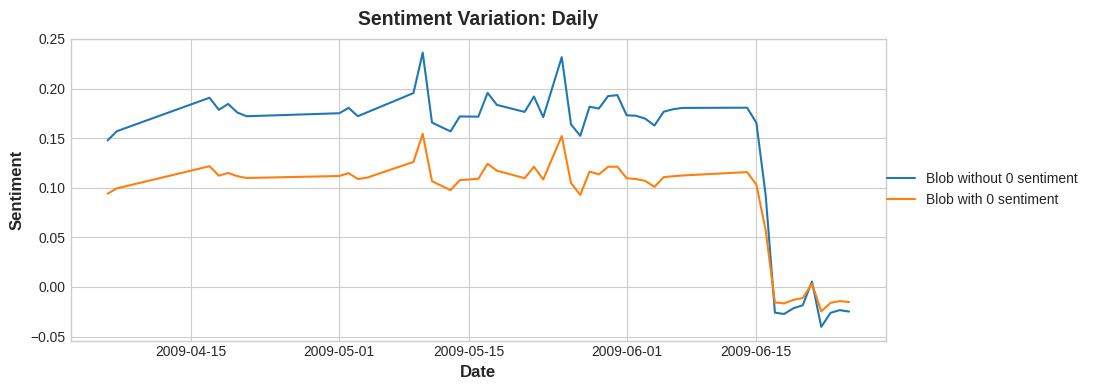

In [42]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict4['date'], dfTweetsPredict4['sentiment_blob'], label='Blob without 0 sentiment');  # Plot first line of data.
ax.plot(dfTweetsPredict44['date'], dfTweetsPredict44['sentiment_blob'], label='Blob with 0 sentiment');  # Plot second line of data

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1.25, 0.5)) #Better positioning the legend

# Data Preparation - Part 2

In [466]:
sqlPrep = """SELECT CONVERT(date_custom, DATE) as date, 
                week,
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
WHERE sentiment_blob != 0
GROUP BY CONVERT(date_custom, DATE), week
ORDER BY CONVERT(date_custom, DATE), week"""


dfTweetsPrep = pd.read_sql(sql = sqlPrep, con = connMySQL)

In [468]:
dfTweetsPrep.head(10)

,date,week,sentiment_blob
0,2009-04-06,Mon,0.147757
1,2009-04-07,Tue,0.157000
2,2009-04-17,Fri,0.190716
3,2009-04-18,Sat,0.178559
4,2009-04-19,Sun,0.184444
5,2009-04-20,Mon,0.175776
6,2009-04-21,Tue,0.172052
7,2009-05-01,Fri,0.175087
8,2009-05-02,Sat,0.180489
9,2009-05-03,Sun,0.172134


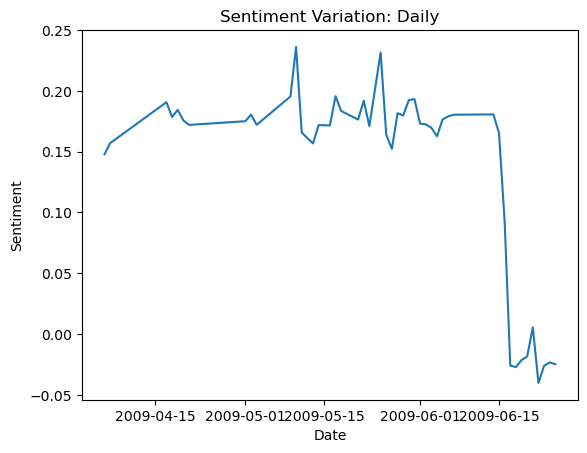

In [469]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPrep['date'], dfTweetsPrep['sentiment_blob'], label='Blob sentiment');  # Plot first line of data.

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.

In [470]:
dfTweetsPrep = dfTweetsPrep.drop(index=[0,1,2,3,4,5,6,7,8,9,36,37,38,39,40,41,42,43,44,45,46,47])
#dfTweetsPrep = dfTweetsPrep.drop(index=[0,1,2,3,4,5,6,7,8,9])


In [471]:
dfTweetsPrep.head(10)

,date,week,sentiment_blob
10,2009-05-04,Mon,0.176000
11,2009-05-09,Sat,0.195401
12,2009-05-10,Sun,0.236198
13,2009-05-11,Mon,0.165693
14,2009-05-13,Wed,0.156789
15,2009-05-14,Thu,0.171866
16,2009-05-16,Sat,0.171639
17,2009-05-17,Sun,0.195656
18,2009-05-18,Mon,0.183491
19,2009-05-21,Thu,0.176416


In [472]:
#new_row = {'date': '2009-06-08', 'week': 'Mon', 'sentiment_blob': 0.173045 }
#dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

#new_row = {'date': '2009-06-09', 'week': 'Tue', 'sentiment_blob': 0.172555 }
#dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

#new_row = {'date': '2009-06-10', 'week': 'Wed', 'sentiment_blob': 0.169671 }
#dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

#new_row = {'date': '2009-06-11', 'week': 'Thu', 'sentiment_blob': 0.162663 }
#dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

#new_row = {'date': '2009-06-12', 'week': 'Fri', 'sentiment_blob': 0.176619 }
#dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

#new_row = {'date': '2009-06-13', 'week': 'Sat', 'sentiment_blob': 0.179096 }
#dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)



In [473]:
# 2009-05-24 value
new_row = {'date': '2009-05-24', 'week': 'Sun', 'sentiment_blob': 0.24 }
dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

# 2009-05-19 value
# to calculate 2009-05-19 value, lets calculate the decrease percentage of change from the 2 values before and apply the same difference
percent = (dfTweetsPrep.iloc[17, 2] * 100 / dfTweetsPrep.iloc[18, 2]) - 100
sent = dfTweetsPrep.iloc[18, 2] - (dfTweetsPrep.iloc[18, 2] * (percent / 100))
new_row = {'date': '2009-05-19', 'week': 'Tue', 'sentiment_blob': sent }
dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

# 2009-05-20 value
# to calculate 2009-05-20 value, lets calculate the decrease percentage of change from the 2 values before and apply the same difference
# same percent before
sent = sent - (sent * (percent / 100))
new_row = {'date': '2009-05-20', 'week': 'Wed', 'sentiment_blob': sent }
dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)


In [474]:
# 2009-05-15 value
# to calculate 2009-05-15 value, lets calculate the average pair values
sent = (dfTweetsPrep.iloc[16, 2] + dfTweetsPrep.iloc[14, 2]) / 2
new_row = {'date': '2009-05-15', 'week': 'Fri', 'sentiment_blob': sent }
dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

# 2009-05-12 value
# to calculate 2009-05-12 value, lets calculate the average pair values
sent = (dfTweetsPrep.iloc[11, 2] + dfTweetsPrep.iloc[13, 2]) / 2
new_row = {'date': '2009-05-12', 'week': 'Tue', 'sentiment_blob': sent }
dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)


Once the trend is a decline of the sentiment from sun to wed and a increase from thu to sun, the value range of the missing days will be calculated based on a continuous increasing/decreasing based on the average of the close avaiable register (MON and SAT):
<br/>
<br/>
<b>2009-05-04 Mon = 0.176000</b>
<br/>
<br/>
2009-05-05 Tue = 0.179233
<br/>
2009-05-06 Wed = 0.182467
<br/>
<br/>
<b>AVERAGE Mon/Sat = 0,1857005</b>
<br/>
<br/>
2009-05-07 Thu = 0.190012
<br/>
2009-05-08 Fri = 0.194323
<br/>
<br/>
<b>2009-05-09 Sat = 0.195401</b>

In [475]:
# 2009-05-05 value
new_row = {'date': '2009-05-05', 'week': 'Tue', 'sentiment_blob': 0.179233 }
dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

# 2009-05-06 value
new_row = {'date': '2009-05-06', 'week': 'Wed', 'sentiment_blob': 0.182467 }
dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

# 2009-05-07 value
new_row = {'date': '2009-05-07', 'week': 'Thu', 'sentiment_blob': 0.190012 }
dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

# 2009-05-08 value
new_row = {'date': '2009-05-08', 'week': 'Fri', 'sentiment_blob': 0.194323 }
dfTweetsPrep = dfTweetsPrep.append(new_row, ignore_index = True)

In [476]:

dfTweetsPrep['date'] = dfTweetsPrep['date'].astype('datetime64[ns]')
dfTweetsPrep['sentiment_blob'] = dfTweetsPrep['sentiment_blob'].astype('float')
dfTweetsPrep.sort_values(by='date', inplace=True)
dfTweetsPrep

,date,week,sentiment_blob
0,2009-05-04,Mon,0.176000
31,2009-05-05,Tue,0.179233
32,2009-05-06,Wed,0.182467
33,2009-05-07,Thu,0.190012
34,2009-05-08,Fri,0.194323
1,2009-05-09,Sat,0.195401
2,2009-05-10,Sun,0.236198
3,2009-05-11,Mon,0.165693
30,2009-05-12,Tue,0.167449
4,2009-05-13,Wed,0.156789


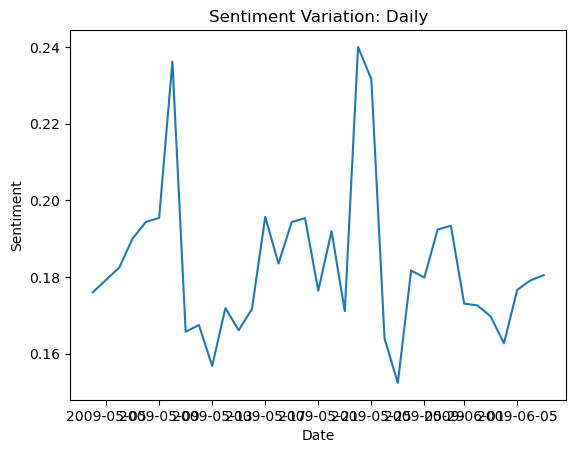

In [477]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPrep['date'], dfTweetsPrep['sentiment_blob'], label='Blob sentiment');  # Plot first line of data.

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.

In [478]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [479]:
dfTweetsPrep2 = dfTweetsPrep

In [480]:
# Data preparation
# ==============================================================================
dfTweetsPrep2['date'] = pd.to_datetime(dfTweetsPrep2['date'], format='%Y/%m/%d')
dfTweetsPrep2 = dfTweetsPrep2.set_index('date')

#dfTweetsPredict7 = dfTweetsPredict7.rename(columns={'sentiment_blob': 'y'})
#dfTweetsPredict7 = dfTweetsPredict7.asfreq('1D')
#dfTweetsPredict7.asfreq(freq = '1H') 
dfTweetsPrep2 = dfTweetsPrep2.sort_index()
#type(dfTweetsPrep2["sentiment_blob"])


In [481]:
#dfTweetsPrep2 = dfTweetsPrep2.drop('week', axis=1)

In [483]:
dfTweetsPrep2.head(10)

,week,sentiment_blob
date,,
2009-05-04,Mon,0.176000
2009-05-05,Tue,0.179233
2009-05-06,Wed,0.182467
2009-05-07,Thu,0.190012
2009-05-08,Fri,0.194323
2009-05-09,Sat,0.195401
2009-05-10,Sun,0.236198
2009-05-11,Mon,0.165693
2009-05-12,Tue,0.167449


In [484]:
result = seasonal_decompose(dfTweetsPrep2['sentiment_blob'], model='additive')

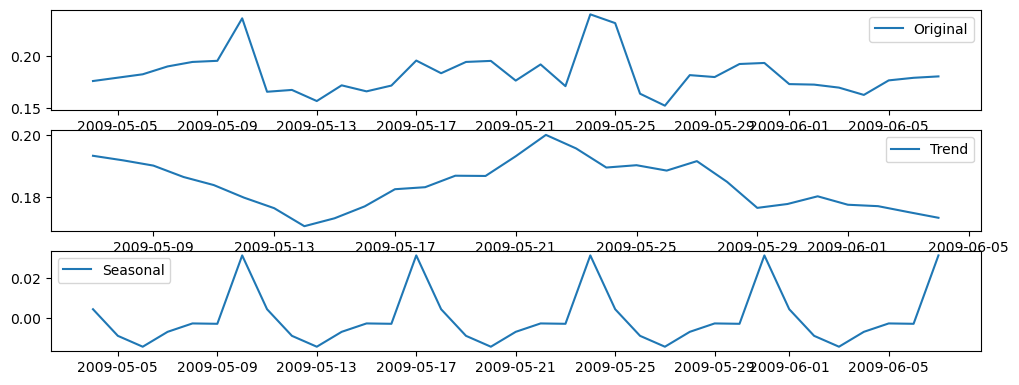

In [485]:
trend = result.trend
seasonal = result.seasonal

plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(dfTweetsPrep2['sentiment_blob'], label='Original')
plt.legend(loc='best')
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

# Modeling - Machine Learning

In [486]:
dfTweetsPredict7 = dfTweetsPrep2

In [487]:
#dfTweetsPredict7
len(dfTweetsPredict7.index)

35

In [488]:
dfTweetsPredict7.loc[dfTweetsPredict7['week'] == 'Mon']

,week,sentiment_blob
date,,
2009-05-04,Mon,0.176000
2009-05-11,Mon,0.165693
2009-05-18,Mon,0.183491
2009-05-25,Mon,0.231595
2009-06-01,Mon,0.173045


In [489]:
dfTweetsPredict7.loc[dfTweetsPredict7['week'] == 'Mon'].mean()[0]

0.1859647256950563

In [366]:
from datetime import timedelta

iTotal = len(dfTweetsPredict7.index)
for i, row in dfTweetsPredict7.iterrows():
    newdate = row["date"] + timedelta(days = iTotal)
    newrow = pd.Series([newdate, row['week'], row['sentiment_blob']], index = dfTweetsPredict7.columns)
    dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True) 
    dfTweetsPredict7.append(row) 
    
iTotal = len(dfTweetsPredict7.index)
for i, row in dfTweetsPredict7.iterrows():
    newdate = row["date"] + timedelta(days = iTotal)
    newrow = pd.Series([newdate, row['week'], row['sentiment_blob']], index = dfTweetsPredict7.columns)
    dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True) 
    dfTweetsPredict7.append(row) 

iTotal = len(dfTweetsPredict7.index)
for i, row in dfTweetsPredict7.iterrows():
    newdate = row["date"] + timedelta(days = iTotal)
    newrow = pd.Series([newdate, row['week'], row['sentiment_blob']], index = dfTweetsPredict7.columns)
    dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True) 
    dfTweetsPredict7.append(row) 
    
iTotal = len(dfTweetsPredict7.index)
for i, row in dfTweetsPredict7.iterrows():
    newdate = row["date"] + timedelta(days = iTotal)
    newrow = pd.Series([newdate, row['week'], row['sentiment_blob']], index = dfTweetsPredict7.columns)
    dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True) 
    dfTweetsPredict7.append(row) 

/tmp/ipykernel_10004/4199310810.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:7: FutureWarning: The frame.append method is deprecated and will be rem

/tmp/ipykernel_10004/4199310810.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:14: FutureWarning: The frame.append method is deprecated and will b

/tmp/ipykernel_10004/4199310810.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:15: FutureWarning: The frame.append method is deprecated and will b

/tmp/ipykernel_10004/4199310810.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:22: FutureWarning: The frame.append method is deprecated and will b

/tmp/ipykernel_10004/4199310810.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:21: FutureWarning: The frame.append method is deprecated and will b

/tmp/ipykernel_10004/4199310810.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:21: FutureWarning: The frame.append method is deprecated and will b

/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will b

/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will b

/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will b

/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will b

/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will b

/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7.append(row)
/tmp/ipykernel_10004/4199310810.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTweetsPredict7 = dfTweetsPredict7.append(newrow, ignore_index = True)
/tmp/ipykernel_10004/4199310810.py:29: FutureWarning: The frame.append method is deprecated and will b

In [490]:
pd.set_option('display.max_rows', None)
dfTweetsPredict7

,week,sentiment_blob
date,,
2009-05-04,Mon,0.176000
2009-05-05,Tue,0.179233
2009-05-06,Wed,0.182467
2009-05-07,Thu,0.190012
2009-05-08,Fri,0.194323
2009-05-09,Sat,0.195401
2009-05-10,Sun,0.236198
2009-05-11,Mon,0.165693
2009-05-12,Tue,0.167449


In [491]:
# Data preparation
# ==============================================================================
#dfTweetsPredict7['date'] = pd.to_datetime(dfTweetsPredict7['date'], format='%Y/%m/%d')
#dfTweetsPredict7 = dfTweetsPredict7.set_index('date')

dfTweetsPredict7 = dfTweetsPredict7.rename(columns={'sentiment_blob': 'y'})
dfTweetsPredict7 = dfTweetsPredict7.asfreq('1D')
#dfTweetsPredict7.asfreq(freq = '1H') 
dfTweetsPredict7 = dfTweetsPredict7.sort_index()
dfTweetsPredict7.head()



,week,y
date,,
2009-05-04,Mon,0.176000
2009-05-05,Tue,0.179233
2009-05-06,Wed,0.182467
2009-05-07,Thu,0.190012
2009-05-08,Fri,0.194323


In [492]:
print(f'Number of rows with missing values: {dfTweetsPredict7.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [493]:
# Verify that a temporary index is complete
# ==============================================================================
(dfTweetsPredict7.index == pd.date_range(start=dfTweetsPredict7.index.min(),
                             end=dfTweetsPredict7.index.max(),
                             freq=dfTweetsPredict7.index.freq)).all()

True

In [494]:
#dfTweetsPredict7["date"][1400]

#dfTweetsPredict7.iloc[1700]


Train dates : 2009-05-04 00:00:00 --- 2009-05-22 00:00:00  (n=19)
Test dates  : 2009-05-23 00:00:00 --- 2009-06-07 00:00:00  (n=16)


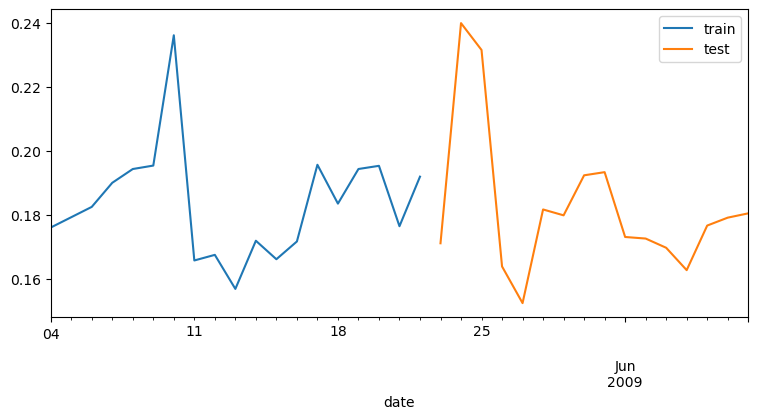

In [498]:
# Split data into train-test
# ==============================================================================
steps = 16
data_train = dfTweetsPredict7[:-steps]
data_test  = dfTweetsPredict7[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax = ax, label='train')
data_test['y'].plot(ax = ax, label='test')
ax.legend();

In [499]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-05-04 00:00:00'), Timestamp('2009-05-22 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-23 10:44:54 
Last fit date: 2023-10-23 10:44:55 
Skforecast version: 0.10.1 
Python version: 3

In [501]:
# Predictions
# ==============================================================================
steps = 16
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2009-05-23    0.169696
2009-05-24    0.166291
2009-05-25    0.171040
2009-05-26    0.167160
2009-05-27    0.199539
Freq: D, Name: pred, dtype: float64

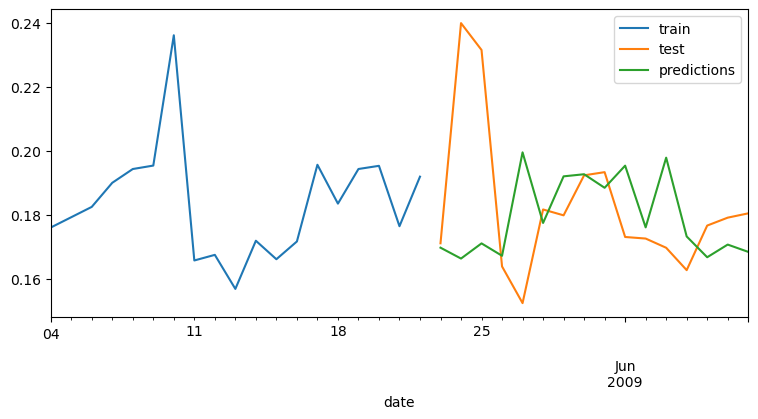

In [502]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [503]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.0008290203743018259


In [504]:
# Save model
dump(forecaster, filename='forecaster.py')

['forecaster.py']

In [505]:
# Load model
forecaster_loaded = load('forecaster.py')

In [ ]:
# Predict
forecaster_loaded.predict(steps = 30)

In [339]:
# Hyperparameter Grid search
# ==============================================================================
steps = 40
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

NameError: name 'grid_search_forecaster' is not defined

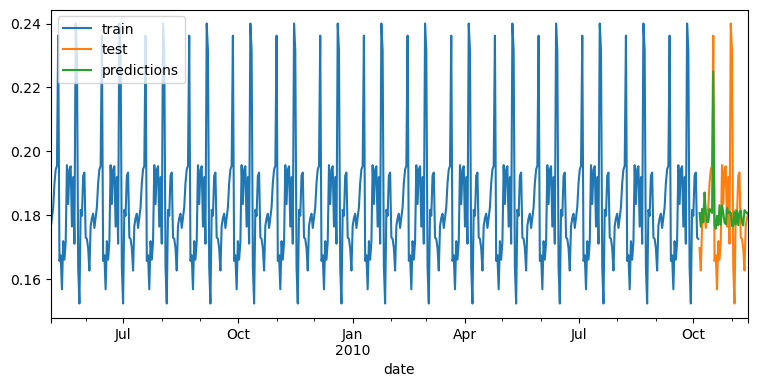

In [352]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

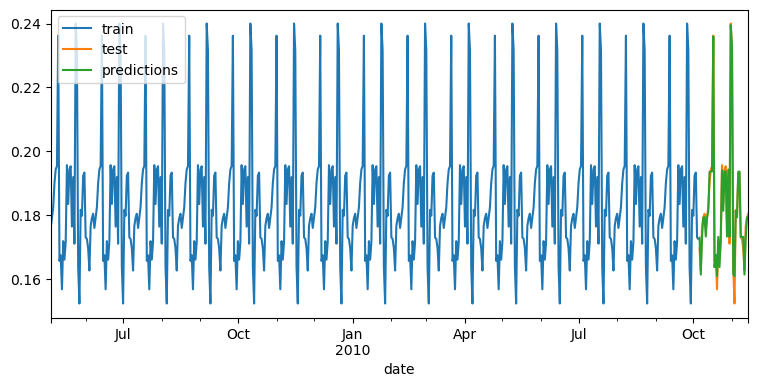

In [353]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 40
             )

forecaster.fit(y=data_train['y'])

# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

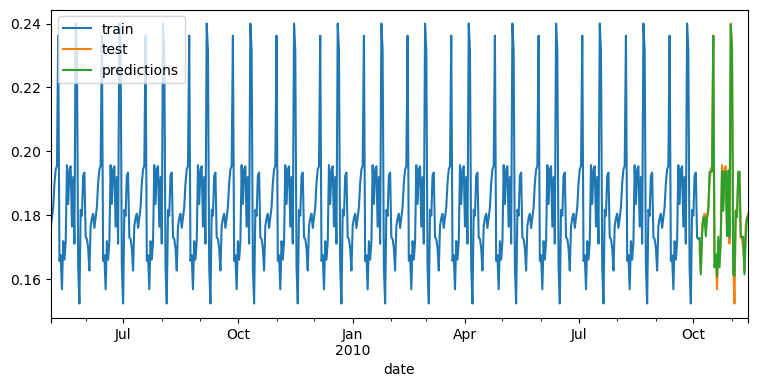

In [354]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 60
             )

forecaster.fit(y=data_train['y'])

# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [355]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")

Test error (mse): 5.404178215209822e-06
